In [1]:
#Все необходимые библиотеки
import pandas as pd
import os
import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch as th

import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread
from torch.utils import data
from tqdm import tqdm

import glob
import re

import time

In [2]:
#Класс для создания общего датасета с метаданными

class CombineDataset(Dataset):

    def __init__(self, frame, id_col, label_name, path_imgs, use_cache = False, transform = None):
        
        self.frame = frame
        self.id_col = id_col
        self.label_name = label_name
        self.path_imgs = path_imgs
        self.inputs_dtype = torch.float32
        
        self.transform = transform
        
        self.use_cache = use_cache
        
        if self.use_cache:
            self.cached_data = []

            progressbar = tqdm(range(len(self.path_imgs)), desc='Caching')
            for i, img in zip(progressbar, self.path_imgs):
                img = Image.open(img)
                if self.transform is not None:
                    img= self.transform(img)
                
                self.cached_data.append(img)
            

    def __len__(self):
        return (self.frame.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = self.cached_data[idx]
        
        #img = torch.from_numpy(img).type(self.inputs_dtype)
        
        #img = self.aug(img)

        feats = [feat for feat in self.frame.columns if feat not in [self.label_name,self.id_col]]
        feats  = np.array(self.frame[feats].iloc[idx])
        feats = feats.tolist()
        feats = torch.FloatTensor(feats)

        label = np.array(self.frame[self.label_name].iloc[idx])
        label = torch.tensor(label, dtype=torch.long)

        return img, feats, label
    
# Определение процессора для обучения 
def get_default_device():
    if torch.cuda.is_available():
        
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [3]:
#Функция для получения веса для каждой категории
def estimate_weights_mfb(label):
    
    class_weights = np.zeros_like(label, dtype=np.float64)
    counts = np.zeros_like(label)
    
    for i,l in enumerate(label):
        
        counts[i] = metadata[metadata['diagnosis']==str(l)]['diagnosis'].value_counts()[0]
    counts = counts.astype(np.float64)
    median_freq = np.median(counts)
    
    for i, label in enumerate(label):
        
        class_weights[i] = median_freq / counts[i]
        
    return class_weights

#Класс для выведения индексов для разделения базы изображений
class Sampler(object):
    def __init__(self, data_source):
        pass
    
    def __iter__(self):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    
    def __init__(self, class_vector, y):
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
             print('Ошибка распределения изображений')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)

In [4]:
#Пути ко всем данным
data_dir = "C:\\Users\\Uliana\\Google Диск\\Базы изображений\\DATASETcat\\"
data_path = torchvision.datasets.ImageFolder(data_dir)
data_label = [s[1] for s in data_path.samples]

metadata = pd.read_csv('C:\\Users\\Uliana\\Google Диск\\Пайтон\\Метаданные\\Таблицы метаданных\\MetaData2.csv')
metadata_path = metadata

#data_dir2 = "C:\\Users\\Uliana\\Google Диск\\Базы изображений\\CLEAN DATASET\\"

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

data_dir2 = sorted(glob.glob('C:\\Users\\Uliana\\Google Диск\\Базы изображений\\CLEAN DATASET\\*.jpg'), key=numericalSort)

#Метки категорий

label = ['actinic keratosis', 'basal cell carcinoma', 'benign ketarosis', 'dermatofibroma', 'melanoma', 'nevus', 'seborrheic keratosis', 'solar lentigo', 'squamous cell carcinoma', 'vascular lesion']

#Необходимые переменные

    #Размер входных изображений
img_size = 227, 227

    #Переменные для выведения индексов разделения базы изображений
test_size = 0.1
val_size = 0.1

    #Переменная для определения количества изображений
batch_size = 32

    #Количество классов
num_classes = 10

    #Количество эпох
num_epochs = 7

    #CPU или GPU
device = get_default_device()
print(device)

cpu


In [5]:
#Кодируем метаданные
label_images = []
le = LabelEncoder()
le.fit(metadata['diagnosis'])
LabelEncoder()

label_encoded1 = le.fit_transform(metadata_path['diagnosis'])
metadata_path['diagnosis'] = label_encoded1

label_encoded2 = le.fit_transform(metadata_path['age'])
metadata_path['age'] = label_encoded2

label_encoded3 = le.fit_transform(metadata_path['sex'])
metadata_path['sex'] = label_encoded3

label_encoded4 = le.fit_transform(metadata_path['anatomloc'])
metadata_path['anatomloc'] = label_encoded4

In [17]:
metadata_path

,name,diagnosis,age,sex,anatomloc
0,ISIC_0010512,0,17,1,1
1,ISIC_0010889,0,7,0,0
2,ISIC_0024468,0,15,1,1
3,ISIC_0024470,0,12,1,7
4,ISIC_0024511,0,11,0,1
...,...,...,...,...,...
41720,ISIC_0072937,9,12,0,3
41721,ISIC_0072964,9,6,1,0
41722,ISIC_0073012,9,12,0,3
41723,ISIC_0073031,9,3,0,3


In [6]:
#Определяем индексы для разделения базы изображений

test_size = 0.2

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()

indices = {'train': pre_train_indices,
           'test': test_indices}


train_indices = indices['train']
test_indices = indices['test']

#Выводим индексы для разделения базы изображений

print("Размер тренировочной базы:", len(train_indices))
print("Размер тестовой базы:", len(test_indices))

Размер тренировочной базы: 33380
Размер тестовой базы: 8345


In [7]:
transform_test = transforms.Compose([
                    transforms.Resize((img_size)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])

In [8]:
test_set = CombineDataset(metadata_path,'name','diagnosis',data_dir2, use_cache = True, transform = transform_test)

Caching: 100%|██████████████████████████████████████████████████████████████████| 41725/41725 [06:26<00:00, 108.06it/s]


In [9]:
validatloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False,  sampler = test_indices)

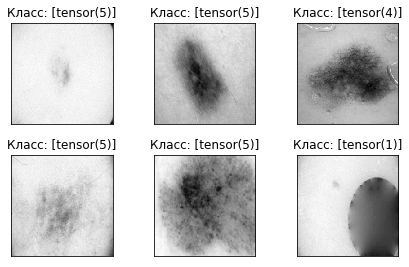

In [10]:
#Вывод примеров изображений

examples = enumerate(validatloader)
batch_idx, (example_data, example_meta, example_targets) = next(examples)
categories = os.listdir(data_dir)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Класс: {}".format([example_targets[i]]))
    plt.xticks([])
    plt.yticks([])

In [11]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[4] = nn.Linear(4096,1024)
alexnet.classifier[6] = nn.Linear(1024,10)

class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet, self).__init__()
        
        self.model = alexnet
        
        self.tabular_layer1 = nn.Linear(3,100)
        self.relu1 = nn.ReLU()
        self.tabular_layer2 = nn.Linear(100,3)
        self.relu2 = nn.ReLU()
        
        #self.meta_net = nn.Sequential(nn.Linear(3, 100), nn.BatchNorm1d(100), nn.ReLU(), nn.Linear(50, 3), nn.BatchNorm1d(3), nn.ReLU())
        
        self.out = nn.Linear(10+3, 10)
                
    def forward(self, img , tab):
        
        img = self.model(img) 
        img = img.reshape(img.shape[0], -1)
        
        #tab = self.meta_net
        tab = self.tabular_layer1(tab)
        tab = self.relu1(tab)
        tab = self.tabular_layer2(tab)
        tab = self.relu2(tab)
        
        x = torch.cat((img, tab),1)
        x = self.out(x)
        
        #x = self.fc1(x)
        
        #x = self.relu4(x)
        
        return x

model = Alexnet()
model = model.to(device)

In [12]:
model_weights = torch.load('C:\\Users\\Uliana\\Google Диск\\Пайтон\\Итоговое моделирование мультимодальной нейросети\\ALEXNET без сегментации\\переменные\\AlexNet_NGD.pt', device)
model.load_state_dict(model_weights)

model = model.to(device)

In [13]:
actuals = []
predictions = []
    
with torch.no_grad():
    
    for data in validatloader:
            
        image, tabular, labels = data
        image, tabular, labels = image.to(device), tabular.to(device), labels.to(device)
            
        output = model(image, tabular)
        
        pred = (torch.max(torch.exp(output), 1)[1]).cpu().data.numpy() 
                
        predictions.extend(pred)
        
        labels = labels.cpu().data.numpy()
        actuals.extend(labels)

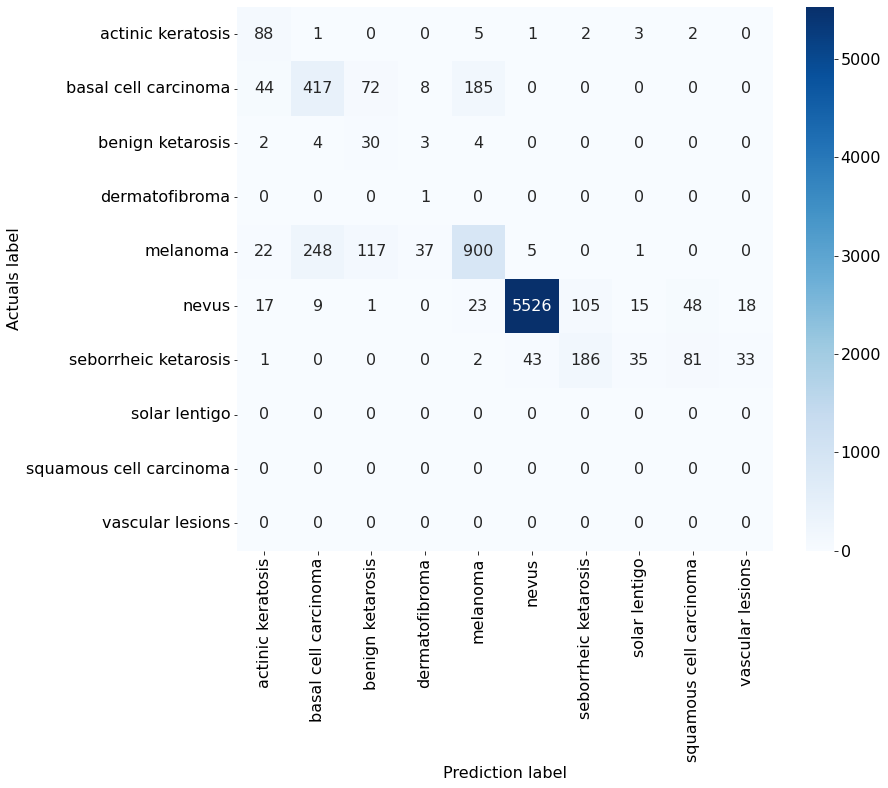

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(predictions, actuals)
df_matrix = pd.DataFrame(matrix, categories, categories)

plt.rcParams['font.size'] = '16'

plt.figure(figsize = (12,10))
sns.heatmap(df_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Prediction label")
plt.ylabel("Actuals label")
plt.show()

In [9]:
#'binary':
#Сообщать результаты только для класса, указанного параметром pos_label. Это применимо, только если цели (y_{true,pred}) являются двоичными.

#'micro':
#Рассчитывайте метрики глобально, подсчитывая общее количество истинных срабатываний, ложноотрицательных и ложноположительных результатов.

#'macro':
#Рассчитайте показатели для каждого ярлыка и найдите их невзвешенное среднее значение. При этом не учитывается дисбаланс меток.

In [15]:
from sklearn.metrics import recall_score

# recall_score = tp / (tp + fn)

recall_1 = recall_score(actuals, predictions, average='micro')
print('Recall micro: %f' % recall_1)

recall_2 = recall_score(actuals, predictions, average='macro')
print('Recall macro: %f' % recall_2)

#recall_3 = recall_score(actuals, predictions, average='binary', pos_label = 0)
#print('Recall binary class benign (0): %f' % recall_3)

#recall_4 = recall_score(actuals, predictions, average='binary', pos_label = 1)
#print('Recall binary class malignant (1): %f' % recall_4)

Recall micro: 0.856561
Recall macro: 0.370697


In [18]:
from sklearn.metrics import precision_score

# precision_score = tp / (tp + fp)

precision_1 = precision_score(actuals, predictions, average='micro')
print('Precision micro: %f' % precision_1)

precision_2 = precision_score(actuals, predictions, average='macro')
print('Precision macro: %f' % precision_2)

#precision_3 = precision_score(actuals, predictions, average='binary', pos_label = 0)
#print('Precision binary class benign (0): %f' % precision_3)

#precision_4 = precision_score(actuals, predictions, average='binary', pos_label = 1)
#print('Precision binary class malignant (1): %f' % precision_4)

Precision micro: 0.856561
Precision macro: 0.525872


C:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
from sklearn.metrics import f1_score

# F1 = 2 * (precision * recall) / (precision + recall)

f1_1 = f1_score(actuals, predictions, average='micro')
print('F1 score micro: %f' % f1_1)

f1_2 = f1_score(actuals, predictions, average='macro')
print('F1 score macro: %f' % f1_2)

#f1_3 = f1_score(actuals, predictions, average='binary', pos_label = 0)
#print('F1 score binary class benign (0): %f' % f1_3)

#f1_4 = f1_score(actuals, predictions, average='binary', pos_label = 1)
#print('F1 score binary class malignant (1): %f' % f1_4)

F1 score micro: 0.856561
F1 score macro: 0.376120


In [20]:
from sklearn.metrics import jaccard_score

# Индекс Жаккара [1] или коэффициент подобия Жаккара, определяемый как размер пересечения, деленный на размер объединения двух наборов меток, используется для сравнения набора предсказанных меток для выборки с соответствующим набором меток в y_true.

jaccard_1 = jaccard_score(actuals, predictions, average='micro')
print('Jaccard score micro: %f' % jaccard_1)

jaccard_2 = jaccard_score(actuals, predictions, average='macro')
print('Jaccard score macro: %f' % jaccard_2)

#jaccard_3 = jaccard_score(actuals, predictions, average='binary', pos_label = 0)
#print('Jaccard score binary class benign (0): %f' % jaccard_3)

#jaccard_4 = jaccard_score(actuals, predictions, average='binary', pos_label = 1)
#print('Jaccard score binary class malignant (1): %f' % jaccard_4)

Jaccard score micro: 0.749109
Jaccard score macro: 0.295244


In [21]:
from sklearn.metrics import accuracy_score

accuracy_1 = accuracy_score(actuals, predictions)
print('Accuracy score: %f' % accuracy_1)

Accuracy score: 0.856561


In [22]:
from sklearn.metrics import matthews_corrcoef

# Коэффициент корреляции Мэтьюса используется в машинном обучении как мера качества бинарных и мультиклассовых классификаций. Он принимает во внимание истинные и ложные положительные и отрицательные результаты и обычно рассматривается как сбалансированная мера, которую можно использовать, даже если классы очень разных размеров. MCC, по сути, представляет собой значение коэффициента корреляции от -1 до +1. Коэффициент +1 представляет собой идеальное предсказание, 0 - среднее случайное предсказание и -1 - обратное предсказание. Эта статистика также известна как фи-коэффициент.

MCC = matthews_corrcoef(actuals, predictions)
print('Matthews corrcoef: %f' % MCC)

Matthews corrcoef: 0.719840


In [23]:
from torchmetrics.functional import hamming_distance

# Расстояние Хэмминга — это метрика для сравнения двух строк двоичных данных. При сравнении двух двоичных строк одинаковой длины расстояние Хэмминга — это количество битовых позиций, в которых два бита различны.

pre = torch.tensor(predictions)
ac = torch.tensor(actuals)

hamming = hamming_distance(pre, ac)
print('Hamming distance: %f' % hamming)

Hamming distance: 0.028688


In [24]:
from torchmetrics import Specificity
import numpy as np

# Specificity = tn / tn + fp

specificity1 = Specificity(average='macro', num_classes=10)
s1 = specificity1(pre, ac)
print('Specificity macro: %f' % s1)

specificity2 = Specificity(average='micro')
s2 = specificity2(pre, ac)
print('Specificity micro: %f' % s2)

specificity3 = Specificity(average='weighted', num_classes=10)
s3 = specificity3(pre, ac)
print('Specificity weighted: %f' % s3)

#specificity4 = Specificity(average='none', num_classes=2)
#s4 = specificity4(pre, ac)
#print('Specificity none - class benign (0): %f' % s4[0])
#print('Specificity none - class malignant (1): %f' % s4[1])

Specificity macro: 0.978746
Specificity micro: 0.984062
Specificity weighted: 0.984062
